# Converting seurat objects to scanpy

In [1]:
DIR="/vast/scratch/users/mueller.h/hackathon"
#source("/Users/harrisonm/data/WEHI/Conferences/OZSC_Hackathon/scripts/st_python/r/utils.R")
#source("/Users/harrisonm/data/WEHI/Conferences/OZSC_Hackathon/scripts/st_python/r/transfer.R")

# Load libraries

In [2]:
library(Seurat)
library(harmony)
library(ggplot2)

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t


Loading required package: Rcpp



### load RDS

In [3]:
atac <- readRDS(file.path(DIR, "data", "qc", "processed_unpaired_ATAC.RDS"))
rna <- readRDS(file.path(DIR, "data", "qc", "processed_Annotated_unpaired_RNA.RDS"))

In [4]:
# add metadata
rna@meta.data["modality"] = "rna"
atac@meta.data["modality"] = "atac"

rna@meta.data["clusters"] = rna@meta.data["seurat_clusters"]
rna@meta.data["cell_type"] = rna@meta.data["Celltype"]

atac@meta.data["clusters"] = atac@meta.data["ATAC_snn_res.0.5"]
atac@meta.data["cell_type"] = "Unknown"

rna$modality = "rna"
atac$modality = "atac"

Loading required package: Signac



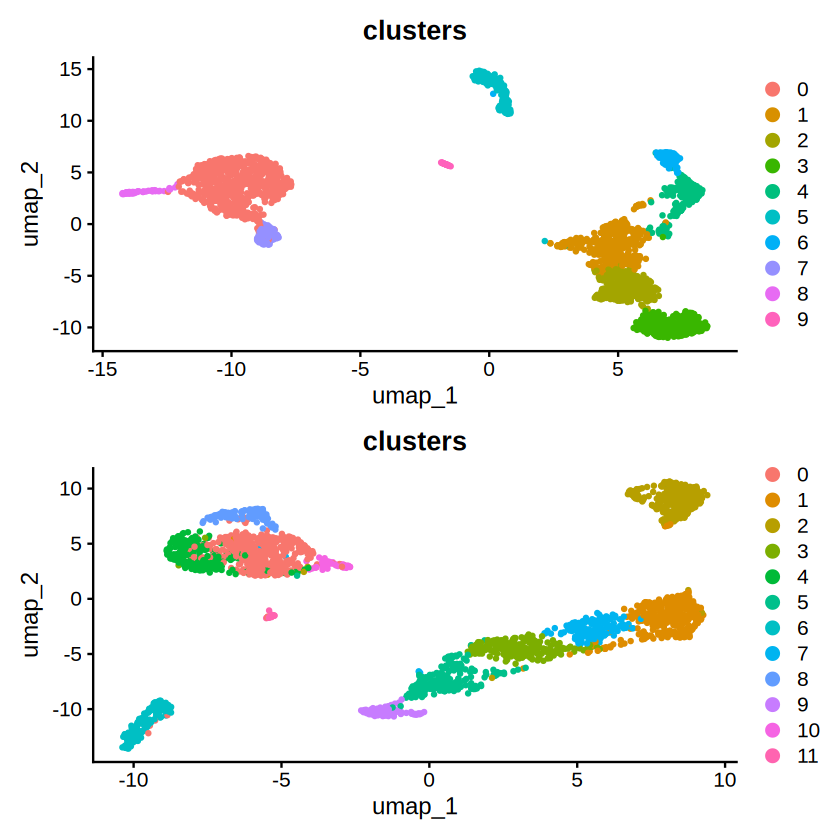

In [5]:
DimPlot(rna, group.by = "clusters") / DimPlot(atac, group.by = "clusters")

## calculate different embeddings

## harmony

In [6]:
# create combined metadata and embeddings
cols_to_keep = c("modality", "clusters", "cell_type")
meta = rbind(rna@meta.data[,cols_to_keep], atac@meta.data[,cols_to_keep])
head(meta)

pca_mat <- Embeddings(rna, "pca")[, 1:20]
lsi_mat <- Embeddings(atac, "lsi")[, 2:21]  # skip LSI 1, which often reflects sequencing depth

embed <- rbind(pca_mat, lsi_mat)
head(embed)

,modality,clusters,cell_type
,<chr>,<fct>,<chr>
AAACAGCCAAATATCC-1,rna,6,NK cells
AAACAGCCAGGAACTG-1,rna,0,Monocytes
AAACAGCCAGGCTTCG-1,rna,0,Monocytes
AAACCAACACCTGCTC-1,rna,5,B cells
AAACCAACAGATTCAT-1,rna,4,T cells
AAACCAACAGTTGCGT-1,rna,2,CD4+ T cells


,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,PC_11,PC_12,PC_13,PC_14,PC_15,PC_16,PC_17,PC_18,PC_19,PC_20
AAACAGCCAAATATCC-1,8.580443,-4.160596,-15.538376,-15.468583,12.130099,0.6755310,-4.1490236,0.4767180,2.0913336,-5.0209922,4.8830071,1.8923778,-0.775623310,0.5147158,0.2183088,1.3122838,-1.1091343,-2.5056487,3.5797958,-1.1999502
AAACAGCCAGGAACTG-1,-17.130967,2.068117,-1.352230,-3.107783,-6.425426,-4.5057583,-2.8389076,-2.8547406,1.2926486,-1.1823351,-1.6354807,1.2684124,1.254506919,5.1897274,-2.8959249,0.3902635,-2.0483504,-0.3212725,-0.0190626,0.2272689
AAACAGCCAGGCTTCG-1,-19.819319,-2.613212,3.480622,4.955077,8.588627,1.7209091,0.8720928,2.2515918,-0.1383927,0.6817977,-1.0311053,-0.9400093,-0.073356871,-4.2637105,-0.9876673,-0.5647223,-0.8763640,0.2245276,0.1493009,0.5542551
AAACCAACACCTGCTC-1,6.377243,15.154342,6.683339,-4.742295,3.045329,-0.5700354,-1.6772153,0.2713507,6.3247608,3.1030492,-0.6541923,-1.9563096,-0.008638781,1.8650211,1.0157896,1.1634820,4.3081989,1.0693332,4.7417050,6.8164065
AAACCAACAGATTCAT-1,9.681480,-4.715767,-8.959457,-9.333708,7.045692,0.1900932,-1.6885692,-1.9841203,-1.2596142,1.1874742,-1.8257149,-1.3798337,2.720772526,1.2089035,2.0033412,-0.1287002,0.3865120,-1.1080431,2.7153246,-0.1268106
AAACCAACAGTTGCGT-1,9.993097,-2.626500,1.884136,1.896700,-1.762768,1.1456350,-1.7314018,0.4796268,-0.8640752,-0.5532302,1.3133298,-2.2142012,0.831420427,-0.4108829,0.2103582,-0.3044289,-0.1174866,1.4890207,-1.2643199,0.4618238


In [8]:
combined <- merge(rna, y = atac)

new_embed = HarmonyMatrix(embed, meta, "modality", do_pca = F, verbose = F)

new_row_names = paste0(rownames(new_embed), meta$modality)

# rename 
rownames(embed)= new_row_names
rownames(new_embed)= new_row_names
rownames(meta) = new_row_names

Warning message:
“Some cell names are duplicated across objects provided. Renaming to enforce unique cell names.”


Warning message in HarmonyMatrix(embed, meta, "modality", do_pca = F, verbose = F):
“HarmonyMatrix is deprecated and will be removed in the future from the API in the future”


In [9]:
so_old <- CreateSeuratObject(counts = t(embed), data = t(embed), meta.data = meta)
so_new <- CreateSeuratObject(counts = t(new_embed), data = t(new_embed), meta.data = meta)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Data is of class matrix. Coercing to dgCMatrix.”


Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Data is of class matrix. Coercing to dgCMatrix.”


In [10]:
so_old <- RunUMAP(so_old, features = 1:20)
so_new <- RunUMAP(so_new, features = 1:20)

Warning message:
“The `slot` argument of `GetAssayData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>.”
Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
16:28:05 UMAP embedding parameters a = 0.9922 b = 1.112

16:28:05 Read 5093 rows and found 20 numeric columns

16:28:05 Using Annoy for neighbor search, n_neighbors = 30

16:28:05 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

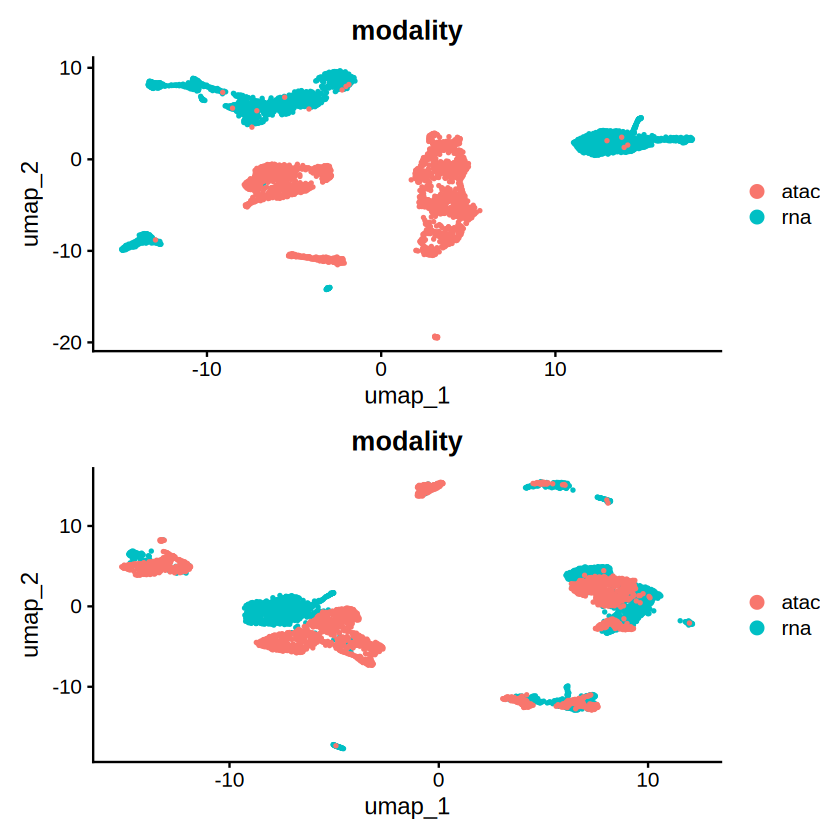

In [11]:
DimPlot(so_old, group.by = "modality") / DimPlot(so_new, group.by = "modality")

### save to file

In [13]:
out = file.path(DIR, "scripts", "hackathon_multiomic_embeddings", "results", "embeddings")
data(so_new)

Warning message in data(so_new):
“data set ‘so_new’ not found”


In [18]:
write.table(t(GetAssayData(so_old, slot = "data")), file = file.path(out, "pca_lsi.tsv"), sep = "\t", quote = FALSE)
write.table(t(GetAssayData(so_new, slot = "data")), file = file.path(out, "harmony_pca_lsi.tsv"), sep = "\t", quote = FALSE)